In [2]:

!git clone https://github.com/MarsImmortal/neural_factorization_machine.git


Cloning into 'neural_factorization_machine'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 160 (delta 70), reused 111 (delta 45), pack-reused 24 (from 1)
Receiving objects: 100% (160/160), 24.31 MiB | 12.47 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [3]:
%cd neural_factorization_machine

/content/neural_factorization_machine


In [11]:
import numpy as np
import os

class LoadData(object):
    '''given the path of data, return the data format for DeepFM
    :param path
    return:
    Train_data: a dictionary, 'Y' refers to a list of y values; 'X' refers to a list of features_M dimension vectors with 0 or 1 entries
    Test_data: same as Train_data
    Validation_data: same as Train_data
    '''

    def __init__(self, path, dataset, loss_type):
        self.path = path + dataset + "/"
        self.trainfile = self.path + dataset +".train.libfm"
        self.testfile = self.path + dataset + ".test.libfm"
        self.validationfile = self.path + dataset + ".validation.libfm"
        self.features_M = self.map_features()
        self.Train_data, self.Validation_data, self.Test_data = self.construct_data(loss_type)

    def map_features(self):
        self.features = {}
        self.read_features(self.trainfile)
        self.read_features(self.testfile)
        self.read_features(self.validationfile)
        return len(self.features)

    def read_features(self, file):
        with open(file) as f:
            line = f.readline()
            i = len(self.features)
            while line:
                items = line.strip().split(' ')
                for item in items[1:]:
                    if item not in self.features:
                        self.features[item] = i
                        i += 1
                line = f.readline()

    def construct_data(self, loss_type):
        X_, Y_, Y_for_logloss = self.read_data(self.trainfile)
        Train_data = self.construct_dataset(X_, Y_for_logloss if loss_type == 'log_loss' else Y_)
        X_, Y_, Y_for_logloss = self.read_data(self.validationfile)
        Validation_data = self.construct_dataset(X_, Y_for_logloss if loss_type == 'log_loss' else Y_)
        X_, Y_, Y_for_logloss = self.read_data(self.testfile)
        Test_data = self.construct_dataset(X_, Y_for_logloss if loss_type == 'log_loss' else Y_)
        return Train_data, Validation_data, Test_data

    def read_data(self, file):
        X_ = []
        Y_ = []
        Y_for_logloss = []
        with open(file) as f:
            line = f.readline()
            while line:
                items = line.strip().split(' ')
                Y_.append(float(items[0]))
                v = 1.0 if float(items[0]) > 0 else 0.0
                Y_for_logloss.append(v)
                X_.append([self.features[item] for item in items[1:]])
                line = f.readline()
        return X_, Y_, Y_for_logloss

    def construct_dataset(self, X_, Y_):
        Data_Dic = {}
        X_lens = [len(line) for line in X_]
        indexs = np.argsort(X_lens)
        Data_Dic['Y'] = [Y_[i] for i in indexs]
        Data_Dic['X'] = [X_[i] for i in indexs]
        return Data_Dic

    def truncate_features(self):
        num_variable = len(self.Train_data['X'][0])
        for i in range(len(self.Train_data['X'])):
            num_variable = min(num_variable, len(self.Train_data['X'][i]))
        for i in range(len(self.Train_data['X'])):
            self.Train_data['X'][i] = self.Train_data['X'][i][:num_variable]
        for i in range(len(self.Validation_data['X'])):
            self.Validation_data['X'][i] = self.Validation_data['X'][i][:num_variable]
        for i in range(len(self.Test_data['X'])):
            self.Test_data['X'][i] = self.Test_data['X'][i][:num_variable]
        return num_variable


In [12]:
class NeuralFM(tf.keras.Model):
    def __init__(self, feature_dim, hidden_factor, layers, keep_prob, loss_type='square_loss', activation='relu'):
        super(NeuralFM, self).__init__()
        self.feature_dim = feature_dim
        self.hidden_factor = hidden_factor
        self.layers_config = layers
        self.keep_prob = keep_prob
        self.loss_type = loss_type
        self.activation = activation

        self.embedding = tf.keras.layers.Embedding(feature_dim, hidden_factor, mask_zero=False)
        self.hidden_layers = [tf.keras.layers.Dense(layer_size, activation=activation) for layer_size in layers]
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid' if loss_type == 'log_loss' else 'linear')
        self.dropout_layers = [tf.keras.layers.Dropout(p) for p in keep_prob]

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        fm_part = tf.reduce_sum(x, axis=1) ** 2 - tf.reduce_sum(x ** 2, axis=1)
        fm_part = 0.5 * tf.reduce_sum(fm_part, axis=1, keepdims=True)

        x = tf.reduce_sum(x, axis=1)
        for layer, dropout in zip(self.hidden_layers, self.dropout_layers):
            x = layer(x)
            if training:
                x = dropout(x)

        x = tf.concat([x, fm_part], axis=1)
        output = self.output_layer(x)
        return output

    def get_config(self):
        return {
            'feature_dim': self.feature_dim,
            'hidden_factor': self.hidden_factor,
            'layers': self.layers_config,
            'keep_prob': self.keep_prob,
            'loss_type': self.loss_type,
            'activation': self.activation,
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)


Num GPUs Available:  0
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - loss: 0.6398 - val_loss: 0.3512
Epoch 2/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.3370 - val_loss: 0.3171
Epoch 3/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 24s 12ms/step - loss: 0.2973 - val_loss: 0.2907
Epoch 4/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - loss: 0.2683 - val_loss: 0.2692
Epoch 5/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.2388 - val_loss: 0.2519
Epoch 6/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.2104 - val_loss: 0.2346
Epoch 7/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.1877 - val_loss: 0.2268
Epoch 8/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.1699 - val_loss: 0.2153
Epoch 9/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.1522 - val_loss: 0.2065
Epoch 10/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.1375 - val_loss: 0.2044
Epoch 11/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.1261 - val_loss: 0.1956
Epoch 12/

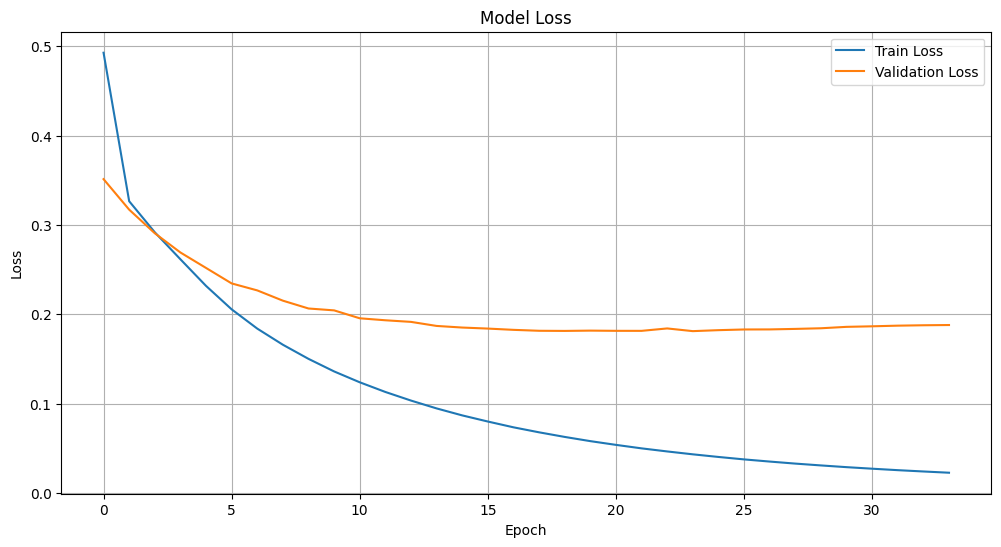

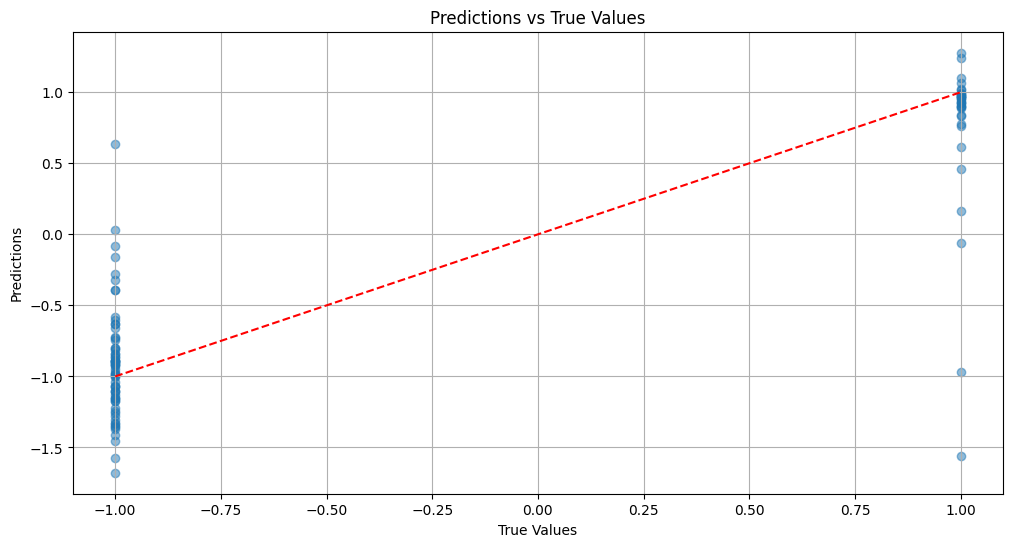

In [13]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import mean_squared_error, log_loss
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision

# Enable mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Allow memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Load data
path = 'data/'
dataset = 'frappe'
loss_type = 'square_loss'  # or 'log_loss'

# Initialize data loader
loader = LoadData(path, dataset, loss_type)
feature_dim = loader.features_M
hidden_factor = 64
layers = [64]
keep_prob = [0.8, 0.5]

# Create model
model = NeuralFM(
    feature_dim=feature_dim,
    hidden_factor=hidden_factor,
    layers=layers,
    keep_prob=keep_prob,
    loss_type=loss_type,
    activation='relu'
)

# Compile model
optimizer = Adagrad(learning_rate=0.05)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy' if loss_type == 'log_loss' else 'mean_squared_error'
)

# Prepare data
def prepare_data(data):
    X = tf.keras.preprocessing.sequence.pad_sequences(data['X'], padding='post')
    y = np.array(data['Y'])
    return X, y

def create_dataset(X, y, batch_size=128, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)  # Adjust buffer size if necessary
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Prepare data
X_train, y_train = prepare_data(loader.Train_data)
X_val, y_val = prepare_data(loader.Validation_data)
X_test, y_test = prepare_data(loader.Test_data)

# Create datasets with batch size
batch_size = 128
train_dataset = create_dataset(X_train, y_train, batch_size=batch_size)
val_dataset = create_dataset(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)

# Define early stopping and TensorBoard callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir="./logs", profile_batch=0)

# Train model with callbacks
history = model.fit(
    train_dataset,
    epochs=200,
    validation_data=val_dataset,
    callbacks=[early_stopping, tensorboard_callback],
    verbose=1
)

# Save the trained model in Keras format
model.save('neural_fm_model.keras')
print("Model saved to neural_fm_model.keras")

# Evaluate model
y_pred = model.predict(test_dataset)
if loss_type == 'log_loss':
    score = log_loss(y_test, y_pred)
else:
    score = mean_squared_error(y_test, y_pred)

print(f"Test {loss_type} score: {score}")

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plot learning curves (if applicable)
# Example: Accuracy curves if you have accuracy metrics
if 'accuracy' in history.history:
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

# Predictions vs True Values (for a small subset)
sample_size = 100
sample_indices = np.random.choice(len(y_test), size=sample_size, replace=False)
y_test_sample = y_test[sample_indices]
y_pred_sample = y_pred[sample_indices]

plt.figure(figsize=(12, 6))
plt.scatter(y_test_sample, y_pred_sample, alpha=0.5)
plt.plot([min(y_test_sample), max(y_test_sample)], [min(y_test_sample), max(y_test_sample)], color='red', linestyle='--')
plt.title('Predictions vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()


In [14]:
from tensorflow.keras.models import load_model
model = load_model('neural_fm_model.keras', custom_objects={'NeuralFM': NeuralFM})


Num GPUs Available:  0
Epoch 1/100
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - loss: 726.4604 - val_loss: 0.3870
Epoch 2/100
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.2685 - val_loss: 0.2983
Epoch 3/100
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.1699 - val_loss: 0.2669
Epoch 4/100
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.1303 - val_loss: 0.2477
Epoch 5/100
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.1077 - val_loss: 0.2364
Epoch 6/100
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.0928 - val_loss: 0.2299
Epoch 7/100
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.0827 - val_loss: 0.2264
Epoch 8/100
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.0739 - val_loss: 0.2207
Epoch 9/100
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.0680 - val_loss: 0.2180
Epoch 10/100
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.0631 - val_loss: 0.2157
Epoch 11/100
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss

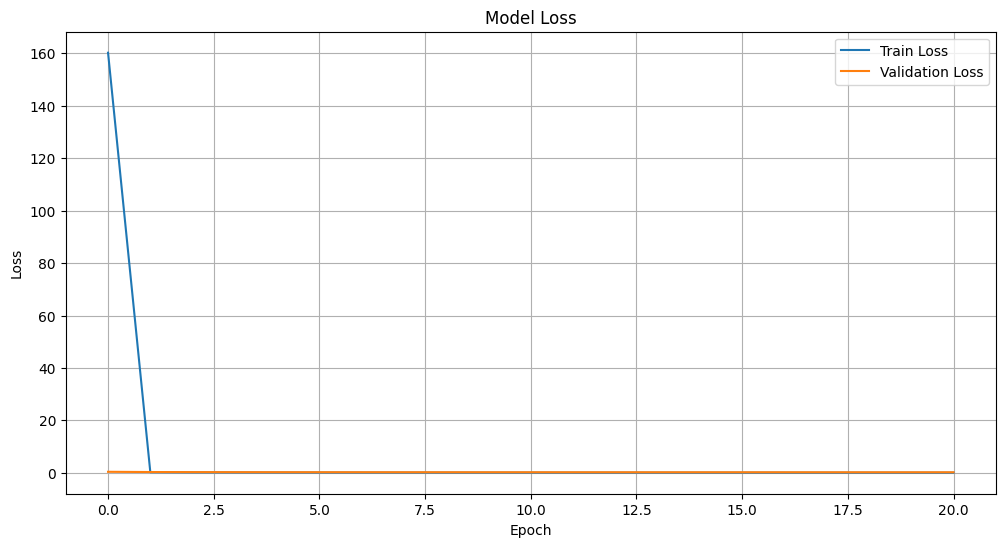

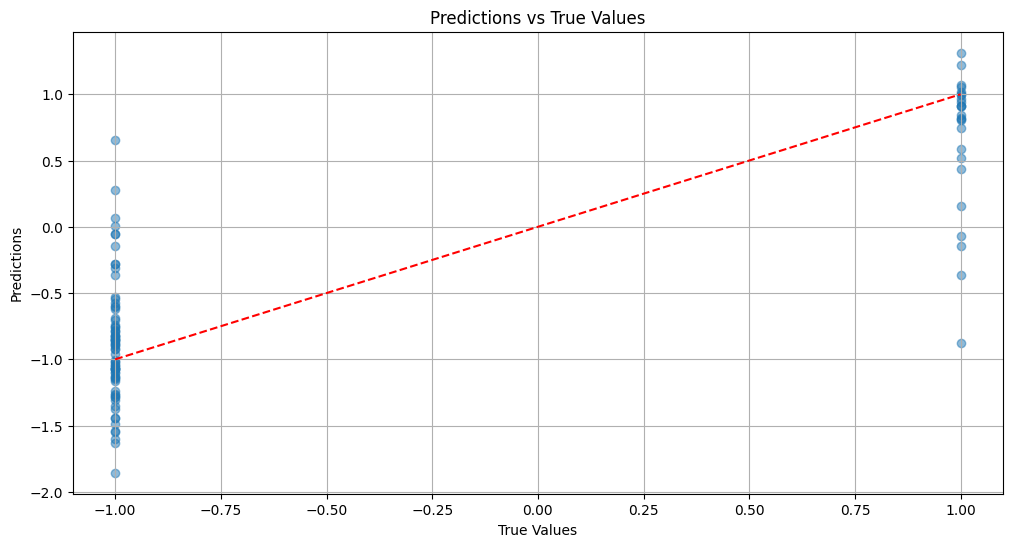

In [19]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision

# Enable mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Allow memory growth for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Load the pre-trained model with the custom NeuralFM class
pretrained_model_path = 'neural_fm_model.keras'

# Load the model with custom_objects
model = tf.keras.models.load_model(pretrained_model_path, custom_objects={'NeuralFM': NeuralFM})

# Compile the model with the same optimizer and loss function
optimizer = Adagrad(learning_rate=0.05)
model.compile(optimizer=optimizer, loss='binary_crossentropy' if loss_type == 'log_loss' else 'mean_squared_error')

# Function to prepare data
def prepare_data(data):
    X = tf.keras.preprocessing.sequence.pad_sequences(data['X'], padding='post')
    y = np.array(data['Y'])
    return X, y

# Function to create dataset
def create_dataset(X, y, batch_size=128, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Prepare data for training, validation, and testing
X_train, y_train = prepare_data(loader.Train_data)
X_val, y_val = prepare_data(loader.Validation_data)
X_test, y_test = prepare_data(loader.Test_data)

batch_size = 128
train_dataset = create_dataset(X_train, y_train, batch_size=batch_size)
val_dataset = create_dataset(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)

# Define early stopping and TensorBoard callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir="./logs", profile_batch=0)

# Continue training the pre-trained model
history = model.fit(
    train_dataset,
    epochs=100,  # You can adjust the number of epochs as needed
    validation_data=val_dataset,
    callbacks=[early_stopping, tensorboard_callback],
    verbose=1
)

# Save the updated model
model.save('neural_fm_model_updated.keras')
print("Updated model saved to neural_fm_model_updated.keras")

# Evaluate the model
y_pred = model.predict(test_dataset)
if loss_type == 'log_loss':
    score = log_loss(y_test, y_pred)
else:
    score = mean_squared_error(y_test, y_pred)

print(f"Test {loss_type} score: {score}")

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Predictions vs True Values for a small subset
sample_size = 100
sample_indices = np.random.choice(len(y_test), size=sample_size, replace=False)
y_test_sample = y_test[sample_indices]
y_pred_sample = y_pred[sample_indices]

plt.figure(figsize=(12, 6))
plt.scatter(y_test_sample, y_pred_sample, alpha=0.5)
plt.plot([min(y_test_sample), max(y_test_sample)], [min(y_test_sample), max(y_test_sample)], color='red', linestyle='--')
plt.title('Predictions vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()


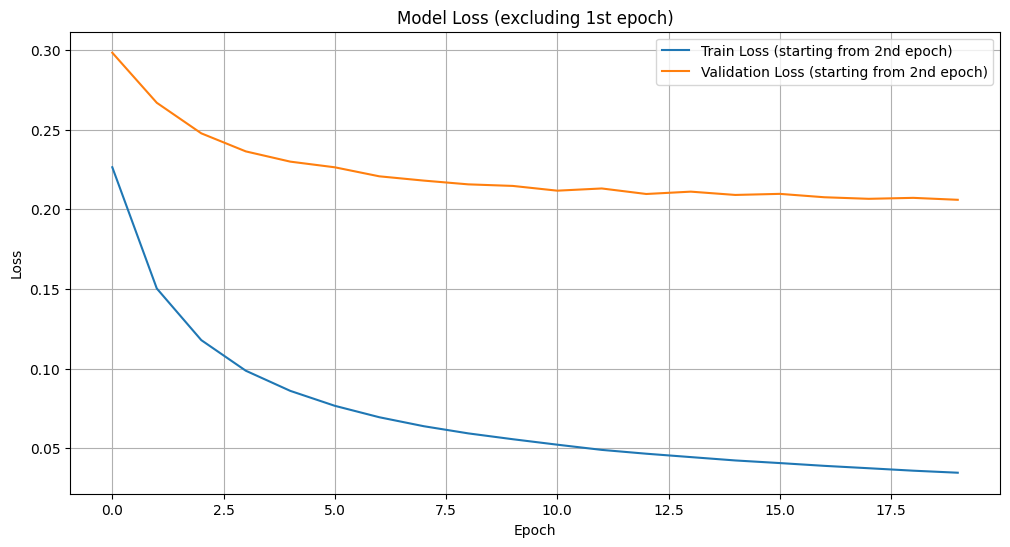

In [20]:
# After training is complete, modify the history to ignore the first epoch
# Get the loss values starting from the second epoch
train_loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

# Plot the training & validation loss values starting from the second epoch
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss (starting from 2nd epoch)')
plt.plot(val_loss, label='Validation Loss (starting from 2nd epoch)')
plt.title('Model Loss (excluding 1st epoch)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Dropout

# Register your custom model class
@tf.keras.utils.register_keras_serializable()
class NeuralFM(tf.keras.Model):
    def __init__(self, feature_dim, hidden_factor, layers, keep_prob, loss_type='square_loss', activation='relu'):
        super(NeuralFM, self).__init__()
        self.embedding = Embedding(feature_dim, hidden_factor, mask_zero=False)
        self.hidden_layers = []
        for layer_size in layers:
            self.hidden_layers.append(Dense(layer_size, activation=activation))
        self.output_layer = Dense(1, activation='sigmoid' if loss_type == 'log_loss' else 'linear')
        self.dropout_layers = [Dropout(p) for p in keep_prob]

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        fm_part = tf.reduce_sum(x, axis=1) ** 2 - tf.reduce_sum(x ** 2, axis=1)
        fm_part = 0.5 * tf.reduce_sum(fm_part, axis=1, keepdims=True)

        x = tf.reduce_sum(x, axis=1)
        for layer, dropout in zip(self.hidden_layers, self.dropout_layers):
            x = layer(x)
            if training:
                x = dropout(x)

        x = tf.concat([x, fm_part], axis=1)
        output = self.output_layer(x)
        return output


# data Visualisation Frappe and ML-tag (movie lens)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_data_distribution(data, dataset_name='Train'):
    """
    Visualizes data distribution for the given dataset (Train/Validation/Test).

    :param data: Dictionary with 'X' and 'Y' values from the LoadData class
    :param dataset_name: 'Train', 'Validation', or 'Test' to indicate which dataset is being visualized
    """
    # Extract features and labels
    X_data = data['X']
    Y_data = data['Y']

    # Plot label distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(Y_data, bins=2, kde=False)
    plt.title(f'Label Distribution in {dataset_name} Dataset')
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.show()

    # Visualizing the sparsity of the feature matrix
    feature_lengths = [len(x) for x in X_data]

    plt.figure(figsize=(10, 5))
    sns.histplot(feature_lengths, bins=30, kde=False)
    plt.title(f'Feature Vector Length Distribution in {dataset_name} Dataset')
    plt.xlabel('Number of Non-Zero Features per Sample')
    plt.ylabel('Frequency')
    plt.show()


In [6]:
import numpy as np

def visualize_sparsity_matrix(data, dataset_name='Train', num_samples=100, num_features=None):
    """
    Visualizes a sample of the feature matrix sparsity using a heatmap.

    :param data: Dictionary with 'X' and 'Y' values from the LoadData class
    :param dataset_name: 'Train', 'Validation', or 'Test' to indicate which dataset is being visualized
    :param num_samples: Number of samples to visualize
    :param num_features: Number of features (optional, required for heatmap)
    """
    # Limit the data to the first `num_samples` entries
    X_data = data['X'][:num_samples]

    if num_features is None:
        raise ValueError("You must provide the total number of features as `num_features`.")

    # Create a binary matrix indicating where non-zero entries exist
    binary_matrix = np.zeros((num_samples, num_features))

    for i, sample in enumerate(X_data):
        for feature in sample:
            binary_matrix[i, feature] = 1

    # Plot the sparsity pattern
    plt.figure(figsize=(15, 8))
    sns.heatmap(binary_matrix, cmap='Blues', cbar=False)
    plt.title(f'Sparsity Pattern of Feature Matrix in {dataset_name} Dataset (First {num_samples} Samples)')
    plt.xlabel('Features')
    plt.ylabel('Samples')
    plt.show()



In [13]:
# loading data
path = 'data/'  # Update this to your actual data path
dataset = 'frappe'  # Replace with your dataset name
loss_type = 'log_loss'  # Or other loss type as needed

# Create an instance of LoadData
loaded_data = LoadData(path, dataset, loss_type)


In [14]:
# Basic stats about the dataset
def display_data_statistics(data_dict, data_type="Train"):
    print(f"Statistics for {data_type} data:")
    num_samples = len(data_dict['Y'])
    num_features = len(data_dict['X'][0]) if num_samples > 0 else 0
    print(f"Number of samples: {num_samples}")
    print(f"Number of features per sample: {num_features}")
    print(f"First few target values (Y): {data_dict['Y'][:5]}")
    print(f"First few feature sets (X): {data_dict['X'][:5]}")
    print("\n")

display_data_statistics(loaded_data.Train_data, "Train")
display_data_statistics(loaded_data.Validation_data, "Validation")
display_data_statistics(loaded_data.Test_data, "Test")


Statistics for Train data:
Number of samples: 202027
Number of features per sample: 10
First few target values (Y): [1.0, 0.0, 1.0, 0.0, 1.0]
First few feature sets (X): [[243, 1939, 48, 30, 20, 5, 6, 80, 8, 9], [726, 1643, 112, 25, 20, 5, 6, 26, 135, 728], [40, 1386, 38, 12, 4, 5, 6, 7, 8, 9], [249, 3454, 18, 42, 20, 5, 6, 7, 54, 251], [890, 218, 18, 42, 20, 13, 6, 7, 150, 892]]


Statistics for Validation data:
Number of samples: 57722
Number of features per sample: 10
First few target values (Y): [0.0, 0.0, 0.0, 1.0, 0.0]
First few feature sets (X): [[665, 2465, 18, 58, 20, 5, 6, 45, 66, 9], [159, 1684, 24, 25, 20, 5, 6, 26, 161, 210], [351, 1793, 38, 19, 20, 5, 6, 26, 62, 702], [307, 2132, 38, 19, 20, 13, 6, 26, 8, 9], [266, 4264, 112, 58, 20, 5, 6, 45, 66, 9]]


Statistics for Test data:
Number of samples: 28860
Number of features per sample: 10
First few target values (Y): [1.0, 0.0, 0.0, 0.0, 0.0]
First few feature sets (X): [[3817, 3182, 38, 12, 4, 13, 6, 72, 8, 884], [362, 477

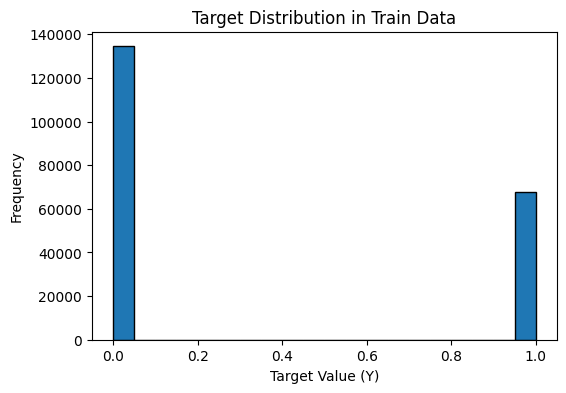

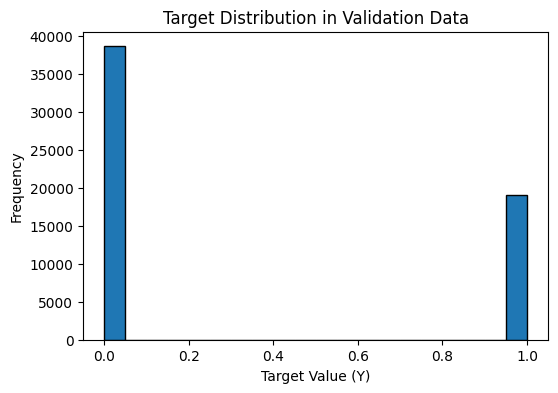

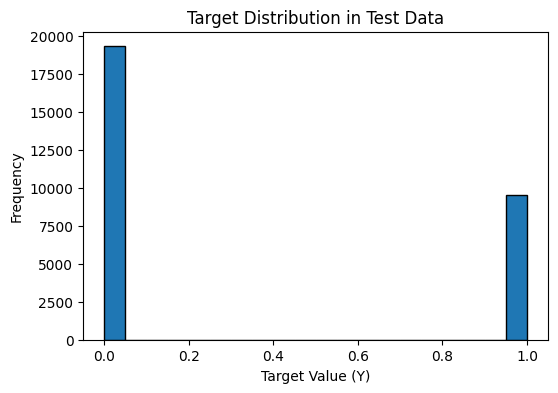

In [16]:
import matplotlib.pyplot as plt

def plot_target_distribution(data_dict, data_type="Train"):
    plt.figure(figsize=(6,4))
    plt.hist(data_dict['Y'], bins=20, edgecolor='black')
    plt.title(f'Target Distribution in {data_type} Data')
    plt.xlabel('Target Value (Y)')
    plt.ylabel('Frequency')
    plt.show()

plot_target_distribution(loaded_data.Train_data, "Train")
plot_target_distribution(loaded_data.Validation_data, "Validation")
plot_target_distribution(loaded_data.Test_data, "Test")


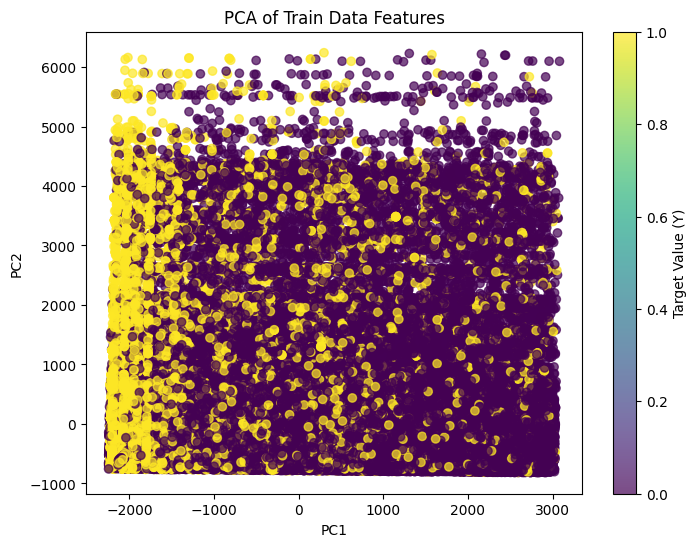

In [19]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_feature_pca(data_dict, data_type="Train"):
    X_data = np.array(data_dict['X'])
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X_data)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=data_dict['Y'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='Target Value (Y)')
    plt.title(f'PCA of {data_type} Data Features')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

plot_feature_pca(loaded_data.Train_data, "Train")


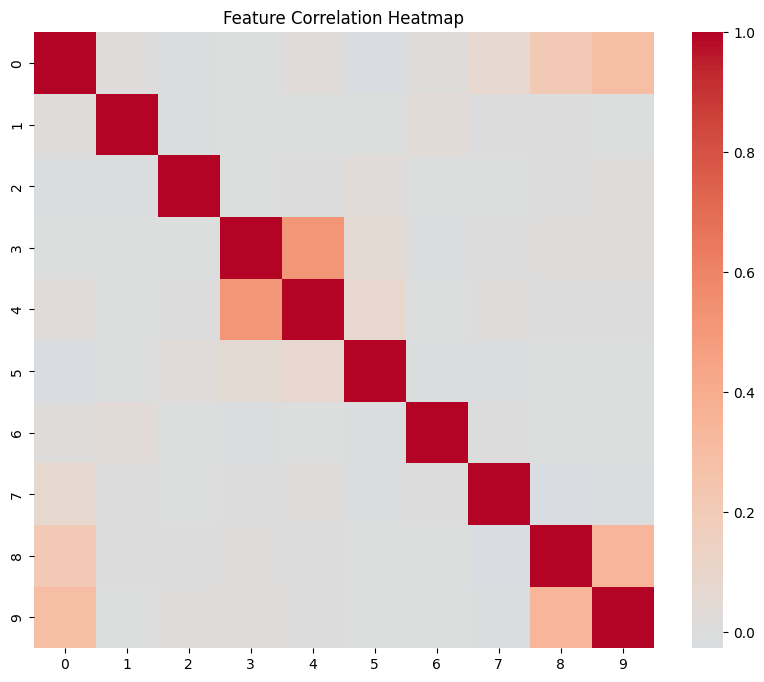

In [23]:
def plot_correlation_heatmap(data_dict):
    X_data = np.array(data_dict['X'])
    corr_matrix = np.corrcoef(X_data.T)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Heatmap')
    plt.show()

plot_correlation_heatmap(loaded_data.Train_data)


In [51]:
# Load the trained model
loaded_model = tf.keras.models.load_model('neural_fm_model.keras', custom_objects={'NeuralFM': NeuralFM})

# Verify the model's architecture and summary
loaded_model.summary()


Model: "neural_fm_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 10, 64)              │         344,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              66 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 697,354 (2.66 MB)

 Trainable params: 348,674 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 348,680 (1.33 MB)

# Attempt to implement multi class NFM

In [24]:
from tensorflow.keras.utils import to_categorical

class LoadData(object):
    def __init__(self, path, dataset, num_classes):
        self.path = path + dataset + "/"
        self.trainfile = self.path + dataset + ".train.libfm"
        self.testfile = self.path + dataset + ".test.libfm"
        self.validationfile = self.path + dataset + ".validation.libfm"
        self.features_M = self.map_features()
        self.num_classes = num_classes
        self.Train_data, self.Validation_data, self.Test_data = self.construct_data()

    def map_features(self):
        self.features = {}
        self.read_features(self.trainfile)
        self.read_features(self.testfile)
        self.read_features(self.validationfile)
        return len(self.features)

    def read_features(self, file):
        with open(file) as f:
            line = f.readline()
            i = len(self.features)
            while line:
                items = line.strip().split(' ')
                for item in items[1:]:
                    if item not in self.features:
                        self.features[item] = i
                        i += 1
                line = f.readline()

    def read_data(self, file):
        X_ = []
        Y_ = []
        with open(file) as f:
            line = f.readline()
            while line:
                items = line.strip().split(' ')
                Y_.append(int(items[0]))  # Assuming labels are integers for multiclass
                X_.append([self.features[item] for item in items[1:]])
                line = f.readline()
        # Convert labels to one-hot encoded vectors for multiclass classification
        Y_onehot = to_categorical(Y_, num_classes=self.num_classes)
        return X_, Y_onehot

    def construct_data(self):
        # Prepare data for train, validation, and test sets
        X_train, Y_train = self.read_data(self.trainfile)
        Train_data = self.construct_dataset(X_train, Y_train)

        X_val, Y_val = self.read_data(self.validationfile)
        Validation_data = self.construct_dataset(X_val, Y_val)

        X_test, Y_test = self.read_data(self.testfile)
        Test_data = self.construct_dataset(X_test, Y_test)

        return Train_data, Validation_data, Test_data

    def construct_dataset(self, X_, Y_):
        Data_Dic = {}
        X_lens = [len(line) for line in X_]
        indexs = np.argsort(X_lens)
        Data_Dic['Y'] = [Y_[i] for i in indexs]
        Data_Dic['X'] = [X_[i] for i in indexs]
        return Data_Dic


In [25]:
import tensorflow as tf

class NeuralFM(tf.keras.Model):
    def __init__(self, feature_dim, hidden_factor, layers, keep_prob, num_classes, activation='relu'):
        super(NeuralFM, self).__init__()
        self.feature_dim = feature_dim
        self.hidden_factor = hidden_factor
        self.layers_config = layers
        self.keep_prob = keep_prob
        self.num_classes = num_classes

        # Embedding layer for factorization machine
        self.embedding = tf.keras.layers.Embedding(feature_dim, hidden_factor, mask_zero=False)

        # Hidden layers for the neural network
        self.hidden_layers = [tf.keras.layers.Dense(layer_size, activation=activation) for layer_size in layers]

        # Output layer for multiclass classification with softmax activation
        self.output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

        # Dropout layers
        self.dropout_layers = [tf.keras.layers.Dropout(p) for p in keep_prob]

    def call(self, inputs, training=False):
        # Embedding lookup
        x = self.embedding(inputs)

        # FM part: Interaction terms between features
        fm_part = tf.reduce_sum(x, axis=1) ** 2 - tf.reduce_sum(x ** 2, axis=1)
        fm_part = 0.5 * tf.reduce_sum(fm_part, axis=1, keepdims=True)

        # NN part: Apply hidden layers
        x = tf.reduce_sum(x, axis=1)
        for layer, dropout in zip(self.hidden_layers, self.dropout_layers):
            x = layer(x)
            if training:
                x = dropout(x)

        # Concatenate FM and NN part
        x = tf.concat([x, fm_part], axis=1)

        # Output layer (softmax for multiclass classification)
        output = self.output_layer(x)
        return output


In [26]:
# Initialize data loader
path = 'data/'
dataset = 'frappe'
num_classes = 3  # Example number of classes

# Load data
loader = LoadData(path, dataset, num_classes)
feature_dim = loader.features_M
hidden_factor = 64
layers = [64]
keep_prob = [0.8, 0.5]

# Create NeuralFM model
model = NeuralFM(
    feature_dim=feature_dim,
    hidden_factor=hidden_factor,
    layers=layers,
    keep_prob=keep_prob,
    num_classes=num_classes,
    activation='relu'
)

# Compile model for multiclass classification
optimizer = Adagrad(learning_rate=0.05)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [27]:
def prepare_data(data):
    X = tf.keras.preprocessing.sequence.pad_sequences(data['X'], padding='post')
    y = np.array(data['Y'])
    return X, y

def create_dataset(X, y, batch_size=128, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Prepare training, validation, and test data
X_train, y_train = prepare_data(loader.Train_data)
X_val, y_val = prepare_data(loader.Validation_data)
X_test, y_test = prepare_data(loader.Test_data)

batch_size = 128
train_dataset = create_dataset(X_train, y_train, batch_size=batch_size)
val_dataset = create_dataset(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir="./logs", profile_batch=0)

# Train model
history = model.fit(
    train_dataset,
    epochs=200,
    validation_data=val_dataset,
    callbacks=[early_stopping, tensorboard_callback],
    verbose=1
)

# Save model
model.save('neural_fm_model_multiclass.keras')


Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.6936 - loss: 0.6179 - val_accuracy: 0.8596 - val_loss: 0.3952
Epoch 2/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.8408 - loss: 0.3943 - val_accuracy: 0.8879 - val_loss: 0.3199
Epoch 3/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.8708 - loss: 0.3348 - val_accuracy: 0.8864 - val_loss: 0.2889
Epoch 4/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.8784 - loss: 0.3076 - val_accuracy: 0.8858 - val_loss: 0.2848
Epoch 5/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.8852 - loss: 0.2887 - val_accuracy: 0.8905 - val_loss: 0.2750
Epoch 6/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.8904 - loss: 0.2739 - val_accuracy: 0.8954 - val_loss: 0.2728
Epoch 7/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.8959 - loss: 0.2624 - val_accuracy: 0.8984 - val_loss: 0.2601
Epoch 8/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.8997 - los

In [28]:
# Evaluate model on test data
y_pred = model.predict(test_dataset)

# Since y_test is one-hot encoded, convert predictions and actuals back to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Evaluate accuracy
accuracy = np.mean(y_pred_classes == y_test_classes)
print(f"Test accuracy: {accuracy}")

# Additional evaluation metrics (optional)
from sklearn.metrics import classification_report
print(classification_report(y_test_classes, y_pred_classes))


226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test accuracy: 0.9402979902979903
              precision    recall  f1-score   support

           1       0.92      0.90      0.91      9536
           2       0.95      0.96      0.96     19324

    accuracy                           0.94     28860
   macro avg       0.93      0.93      0.93     28860
weighted avg       0.94      0.94      0.94     28860

